In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from astropy.io import fits
import scienceplots
plt.style.use(['science', 'notebook', 'grid'])
import Sigma_psi

In [2]:
filename = "/Users/timotheschmidt/Documents/MINES/2A/Stage PNU/Simu/DATA_SIMS/Output00034_size0128_hyperCube.fits"
file = fits.open(filename)
filename2 = "/Users/timotheschmidt/Documents/MINES/2A/Stage PNU/Simu/DATA_SIMS/Output00034_size0128_cube_temp.fits"
file2 = fits.open(filename2)

# Computing $\sigma_v$
To get the velocity dispersion, we will use the brightness temperature. Brightness temperature or radiance temperature is the temperature at which a black body in thermal equilibrium with its surroundings would have to be in order to duplicate the observed intensity of a grey body object at a frequency $\nu$.

In our case, its expression is :
$$
T_B (x,y,u) = \dfrac{1}{C\sqrt{2\pi}}\sum_z \dfrac{n(x,y,z)}{\sigma} \times \exp \left(- \dfrac{(u - v(x,y,z))^2}{2\sigma^2} \right)
$$
where $C = 1.813 \times 10^{18} \:\text{cm}^{-2}$,  $\sigma^2 = k_b T(x,y,z)/m$, m being the mass of the hydrogen atom.


The velocity centroid map is the average of the velocity as
weighted by the brightness temperature at each position on the
sky:

$$
C(x,y) = \dfrac{\sum_u u \, T_B (x,y,u)}{\sum_u  T_B (x,y,u)}
$$

Then the velocity dispersion is 
$$
\sigma_v = \dfrac{\sum_u u^2 \, T_B (x,y,u)}{\sum_u  T_B (x,y,u)} - C(x,y)^2
$$

### Computing the brightness temperature

In [3]:
def Tb_u(x, y, u):     
    C = 1.813e18
    L = 50 * 3.086e18 # longueur du cube en cm
    dz = L/128 
    v = file[3].data[x,y,:] # en km/s
    n = file[0].data[x,y,:] 
    T = file2[0].data[x,y,:] 
    k_b = 1.38e-23 
    m = 1.67e-27
    U = np.ones((128,)) * u
    sigma = np.sqrt(k_b*T/m) / 10**3
    
    A = n/sigma * np.exp(-(U - v)**2 /(2 * sigma**2))

    return np.sum(A) * (dz / (C * np.sqrt(2*np.pi))) 
    

In [4]:
def Tb(x, y, u_max, u_min, du):
    """creating the vector of brightness temperature for every velocity"""
    du = (u_max - u_min)/1000 
    U = np.arange(u_min, u_max, du)
    Tb = []
    for u in U :
        Tb.append(Tb_u(x, y, u))
    return(Tb)

Text(0, 0.5, '$T_b$ [K]')

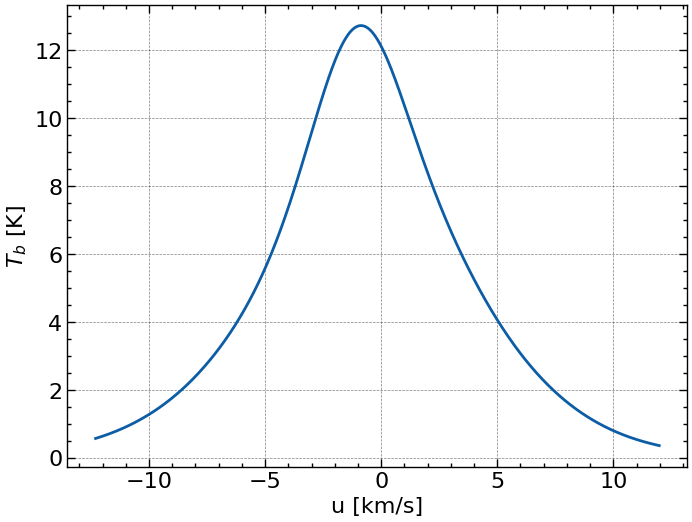

In [8]:
x = 10
y = 47
u_max =  12
u_min = -12.3
du = (u_max - u_min)/1000 


U = np.arange(u_min, u_max, du)
Temp = Tb(x, y, u_max, u_min, du)

plt.plot(U, Temp)
plt.xlabel("u [km/s]")
plt.ylabel("$T_b$ [K]")


In [9]:
def C(x,y):
    """Velocity centroid"""
    Num = 0
    Den = 0
    u_max = 12.1
    u_min = -12.3
    du = (u_max - u_min)/1000 
    U = np.arange(u_min, u_max, du)
    
    for u in U:
        Num += u * Tb_u(x,y,u) 
        Den += Tb_u(x,y,u) 
    
    return Num/Den


In [10]:
def sigma_v(x,y):
    Num = 0
    Den = 0
    u_max = 12.1
    u_min = -12.3
    du = 0.1
    n = int((u_max - u_min)/du) + 1
    U = np.linspace(u_min, u_max, n)
    
    for u in U:
        Num += u**2 * Tb_u(x,y,u) 
        Den += Tb_u(x,y,u) 
    
    return np.sqrt(Num/Den - C(x,y)**2)


In [11]:
def sigma_v_t(x,y):
    """true value of sigma_v"""
    return np.std(file[3].data[x,y,:])

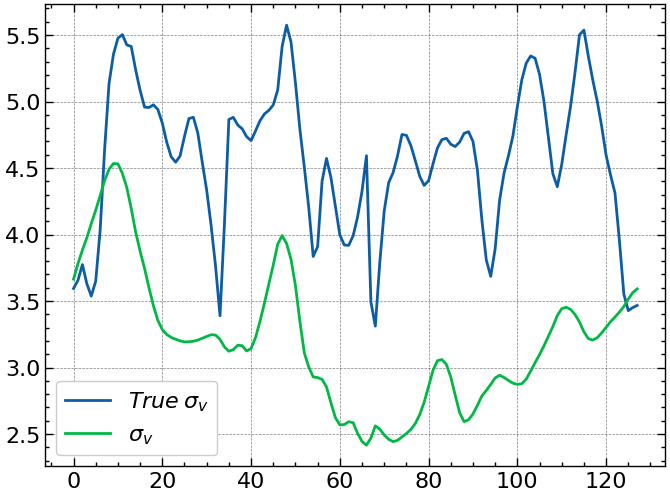

In [13]:
Sigma_exp = [sigma_v(x,100) for x in range(128)]
Sigma_t = [sigma_v_t(x,100) for x in range(128)]
X = np.arange(0, 128, 1)

plt.plot(X, Sigma_exp, label = "$True \: \sigma_v$")
plt.plot(X, Sigma_t, label = "$\sigma_v$")
plt.legend()

In [14]:
def B(file,x,y,z):
    """Estimation of B using the test formula"""
    return np.sqrt(4/3 * np.pi * file[0].data[x,y,z]) * sigma_v(x,y)/Sigma_psi.sigma_psi_global()

def B_semi(file,x,y,z):
    """same as B but using the true value of sigma_v"""
    return np.sqrt(4/3 * np.pi * file[0].data[x,y,z]) * sigma_v_t(x,y)/Sigma_psi.sigma_psi_global()



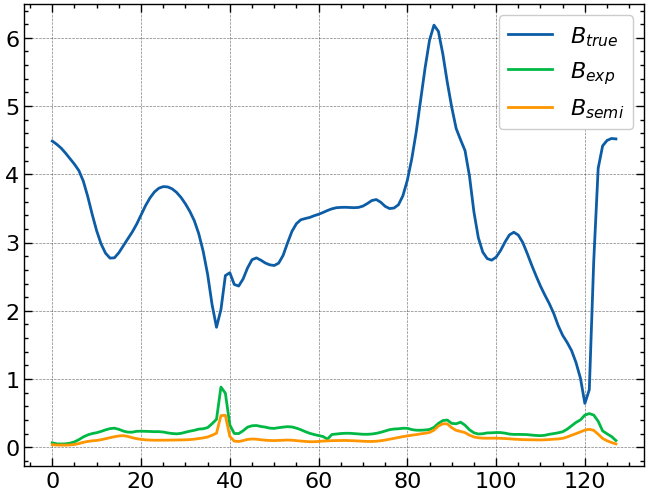

In [15]:
def B_true(y,z):
    """ true value of the projection of B on the (x,y) plane, at the line (y,z)"""
    Bx = file[4].data[:,y,z]
    By = file[5].data[:,y,z]
    B = np.sqrt(Bx**2 + By**2)
    return B

B_t = B_true(50,50)
B_exp = [B(file,x,50,50) for x in range(128)]
B_semi = [B_semi(file,x,50,50) for x in range(128)]
X = np.arange(0, 128, 1)

plt.plot(X, B_t, label = "$B_{true}$")
plt.plot(X, B_exp, label = "$B_{exp}$")
plt.plot(X, B_semi, label = "$B_{semi}$")
plt.legend()

## Checking $T_B$ formula

Let's check that we indeed have this equality for the density column : 
$$
\int_0 ^L n(x,y,z) dz = A \int_{LOS} T_B(u) du
$$
Where A is a constant.





In [16]:
def N(x,y):
    
    return np.sum(file[0].data[x,y,:])


def N_Tb(x,y):
    N2 = 0
    for u in U:
        N2 += Tb_u(x,y,u) * du
        
    return N2

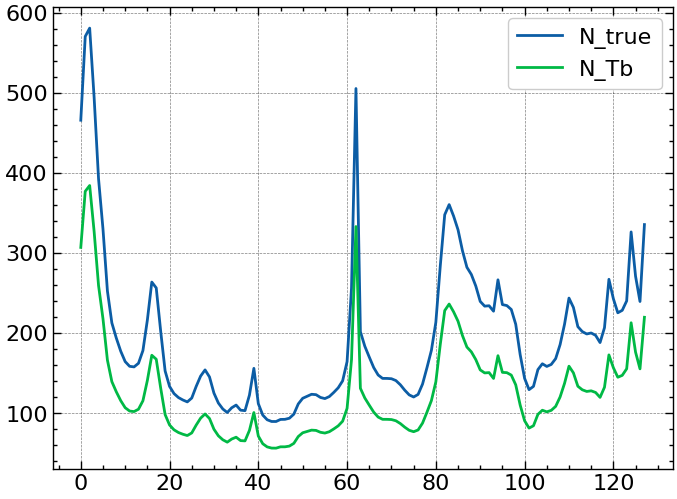

In [17]:
X = np.arange(0, 128, 1)
N1 = [N(x,50) for x in range(128)]
N2 = [N_Tb(x,50) for x in range(128)]
plt.plot(X, N1, label = 'N_true')
plt.plot(X, N2, label = 'N_Tb')
plt.legend()